In [1]:
# Librerías utilizadas por el script
import timm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fastai.vision.all import *
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
import torch

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [3]:
torch.cuda.is_available()

True

In [4]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fasst.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [5]:
df = pd.read_csv('trainSet.csv')

In [6]:
def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
        return ((el['class'].values[0]))
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]
        return ((el['class'].values[0]))

In [7]:
"""## Normalización

import os
import numpy as np
from PIL import Image

# Directorio donde se encuentran las imágenes
directorio_imagenes = "trainThumbnails"

# Lista para almacenar los valores de brillo promedio de las imágenes
im_colors = []

# Recorre todas las imágenes en el directorio
for filename in os.listdir(directorio_imagenes):
    ruta_completa = os.path.join(directorio_imagenes, filename)
    imagen = Image.open(ruta_completa)
    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)
    media = np.mean(imagen)
    im_colors.append(media)

# Calcula la media y la desviación estándar de los valores de brillo
med_col= np.mean(im_colors)
desv_col = np.std(im_colors)

print(f"Media: {med_col:.2f}")
print(f"Desviación estándar: {desv_col:.2f}")"""

'## Normalización\n\nimport os\nimport numpy as np\nfrom PIL import Image\n\n# Directorio donde se encuentran las imágenes\ndirectorio_imagenes = "trainThumbnails"\n\n# Lista para almacenar los valores de brillo promedio de las imágenes\nim_colors = []\n\n# Recorre todas las imágenes en el directorio\nfor filename in os.listdir(directorio_imagenes):\n    ruta_completa = os.path.join(directorio_imagenes, filename)\n    imagen = Image.open(ruta_completa)\n    # Calcula el brillo promedio de la imagen (puedes adaptar esto según tus necesidades)\n    media = np.mean(imagen)\n    im_colors.append(media)\n\n# Calcula la media y la desviación estándar de los valores de brillo\nmed_col= np.mean(im_colors)\ndesv_col = np.std(im_colors)\n\nprint(f"Media: {med_col:.2f}")\nprint(f"Desviación estándar: {desv_col:.2f}")'

In [8]:
# División en 70% train y 30% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.4, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=32)

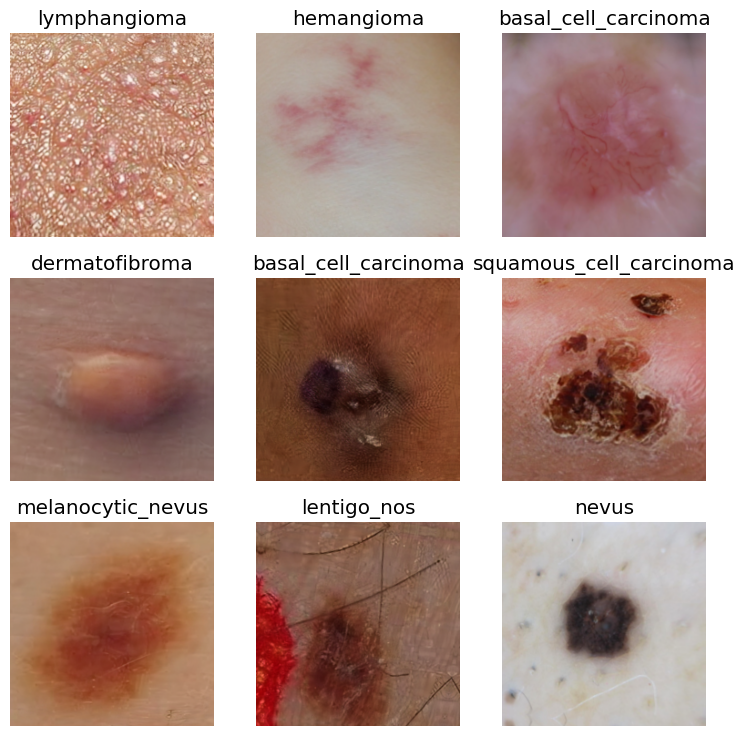

In [9]:
trainSet.show_batch()  # shows a batch of images

In [10]:
# Calcula la frecuencia de cada clase

class_frequencies = df["class"].value_counts()
class_weights = 1 / class_frequencies

print(class_weights)

class_weights = torch.cuda.FloatTensor(class_weights).cuda()

class
nevus                                 0.000047
seborreic_keratosis                   0.000148
basal_cell_carcinoma                  0.000177
melanoma                              0.000208
actinic_keratosis                     0.000303
wart                                  0.000323
melanocytic_nevus                     0.000351
epidermal_cyst                        0.000356
dermatofibroma                        0.000386
squamous_cell_carcinoma               0.000390
hemangioma                            0.000491
lentigo_nos                           0.001047
pigmented_benign_keratosis            0.001245
pyogenic_granuloma                    0.001718
intraepithelial_carcinoma             0.001815
neurofibroma                          0.002208
solar_lentigo                         0.002967
syringoma                             0.003774
blue_nevus                            0.004717
vascular_lesion                       0.004785
melanoma_metastasis                   0.004926
venous_

/tmp/ipykernel_87164/684520669.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = torch.cuda.FloatTensor(class_weights).cuda()
/tmp/ipykernel_87164/684520669.py:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  class_weights = torch.cuda.FloatTensor(class_weights).cuda()


In [11]:
efnet_3_learner = vision_learner(trainSet, 'tf_efficientnet_lite3', loss_func=FocalLoss(), metrics=[accuracy, error_rate],pretrained=True)
efnet_3_learner.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 112 x 112 
Conv2dSame                                864        False     
Identity                                                       
ReLU6                                                          
Conv2d                                    288        False     
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     32 x 24 x 112 x 112 
Conv2d                                    768        False     
Identity                                                       
Identity                                                       
____________________________________________________________________________
             

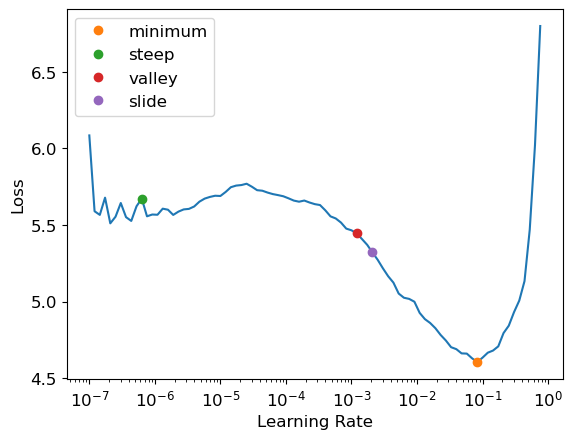

In [12]:
lrs = efnet_3_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))


In [13]:
print(trainSet.vocab)

['acrochordon', 'actinic_keratosis', 'aimp', 'angiokeratoma', 'angioma', 'angiosarcoma', 'atypical nevus', 'atypical_melanocytic_proliferation', 'basal_cell_carcinoma', 'becker_nevus', 'blue_nevus', 'congenital_nevus', 'dermatofibroma', 'dfsp', 'epidermal_cyst', 'epidermal_nevus', 'hemangioma', 'intraepithelial_carcinoma', 'kaposi_sarcoma', 'keratoacanthoma', 'lentigo_nos', 'lentigo_simplex', 'lichenoid_keratosis', 'lymphangioma', 'malignant_melanoma', 'melanocytic_nevus', 'melanoma', 'melanoma_metastasis', 'milia', 'mucocele', 'mucosal_melanotic_macule', 'neurofibroma', 'nevus', 'organoid_nevus', 'ota_nevus', 'pigmented_benign_keratosis', 'poro_keratosis', 'poroma', 'port_wine_stain', 'pyogenic_granuloma', 'scar', 'sebaceous_hyperplasia', 'seborreic_keratosis', 'skin_tag', 'solar_lentigo', 'spitz_nevus', 'squamous_cell_carcinoma', 'syringoma', 'vascular_lesion', 'venous_lake', 'verruca', 'wart', 'xanthelasma']


In [14]:
print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

Valores propuestos:  SuggestedLRs(minimum=0.00831763744354248, steep=6.309573450380412e-07, valley=0.0012022644514217973, slide=0.0020892962347716093)

Valle (Smith Fit One cycle) 0.0012022644514217973


In [15]:
efnet_3_learner.fine_tune(20, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.661648,1.371264,0.489558,0.510442,03:41


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.395749,1.189076,0.526087,0.473913,03:46
1,1.283310,1.148863,0.537955,0.462045,03:46
2,1.201815,1.098598,0.549129,0.450871,03:46
3,1.130387,1.052681,0.558685,0.441315,03:46
4,1.106988,1.015917,0.572557,0.427443,03:44
5,1.033175,0.986622,0.575871,0.424129,03:45
6,0.958311,0.937652,0.595677,0.404323,03:40
7,0.953917,0.908476,0.604655,0.395345,03:39
8,0.904610,0.894465,0.606042,0.393958,03:39
9,0.866951,0.874372,0.614326,0.385674,03:40


No improvement since epoch 14: early stopping


In [16]:
interp = ClassificationInterpretation.from_learner(efnet_3_learner, 1, trainSet.valid)

preds, targets = efnet_3_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [17]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")

Balanced accuracy: 27.6197
Precision: 62.1447
F1 Score: 61.8659


/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.03      0.06        64
           1       0.51      0.49      0.50      1313
           2       0.17      0.03      0.06        30
           3       0.56      0.16      0.24        32
           4       0.50      0.17      0.25        12
           5       0.38      0.25      0.30        12
           6       0.60      0.16      0.25        19
           7       0.00      0.00      0.00        29
           8       0.55      0.59      0.57      2166
           9       0.67      0.46      0.55        13
          10       0.38      0.27      0.32        88
          11       0.40      0.06      0.11        32
          12       0.53      0.59      0.56      1022
          13       0.00      0.00      0.00        10
          14       0.55      0.69      0.61      1126
          15       0.67      0.07      0.12        30
          16       0.68      0.61      0.64       817
          17       0.56    

/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristhian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import os
import numpy as np
from PIL import Image
from multiprocessing import Pool, cpu_count

def cargar_imagen(ruta_imagen):
    imagen = Image.open(ruta_imagen)
    matriz_rgb = np.array(imagen)
    return matriz_rgb

def calcular_estadisticas_canal(canal):
    valores_canal = canal.flatten()
    media = np.mean(valores_canal)
    desviacion = np.std(valores_canal)
    return media, desviacion

def calcular_estadisticas_imagenes(directorio):
    archivos_imagen = [archivo for archivo in os.listdir(directorio) if archivo.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Cargar imágenes en paralelo
    with Pool(processes=cpu_count()) as pool:
        matrices_rgb = pool.map(cargar_imagen, [os.path.join(directorio, archivo) for archivo in archivos_imagen])

    # Calcular estadísticas de los canales RGB en paralelo
    with Pool(processes=cpu_count()) as pool:
        resultados = pool.map(calcular_estadisticas_canal, [matriz_rgb[:, :, i] for i in range(3)])

    media_rojo, desviacion_rojo = resultados[0]
    media_verde, desviacion_verde = resultados[1]
    media_azul, desviacion_azul = resultados[2]

    return media_rojo, media_verde, media_azul, desviacion_rojo, desviacion_verde, desviacion_azul

# Directorio que contiene tus imágenes
directorio_imagenes = "trainThumbnails"

# Calcular estadísticas en paralelo
media_r, media_g, media_b, desviacion_r, desviacion_g, desviacion_b = calcular_estadisticas_imagenes(directorio_imagenes)

print(f"Media (Rojo): {media_r:.2f}")
print(f"Media (Verde): {media_g:.2f}")
print(f"Media (Azul): {media_b:.2f}")
print(f"Desviación estándar (Rojo): {desviacion_r:.2f}")
print(f"Desviación estándar (Verde): {desviacion_g:.2f}")
print(f"Desviación estándar (Azul): {desviacion_b:.2f}")

# Clasificación binaria

In [19]:
print(df['class'].unique())

['squamous_cell_carcinoma' 'melanoma' 'actinic_keratosis' 'dermatofibroma' 'nevus' 'melanocytic_nevus' 'basal_cell_carcinoma' 'angiokeratoma' 'melanoma_metastasis' 'wart' 'seborreic_keratosis'
 'neurofibroma' 'hemangioma' 'syringoma' 'epidermal_cyst' 'pyogenic_granuloma' 'intraepithelial_carcinoma' 'lentigo_nos' 'acrochordon' 'pigmented_benign_keratosis' 'solar_lentigo' 'becker_nevus'
 'congenital_nevus' 'poroma' 'venous_lake' 'blue_nevus' 'skin_tag' 'organoid_nevus' 'verruca' 'atypical nevus' 'mucosal_melanotic_macule' 'mucocele' 'epidermal_nevus' 'port_wine_stain'
 'kaposi_sarcoma' 'atypical_melanocytic_proliferation' 'lichenoid_keratosis' 'sebaceous_hyperplasia' 'lentigo_simplex' 'xanthelasma' 'aimp' 'angioma' 'vascular_lesion' 'poro_keratosis' 'milia' 'dfsp'
 'lymphangioma' 'spitz_nevus' 'ota_nevus' 'angiosarcoma' 'scar' 'keratoacanthoma' 'malignant_melanoma']


In [20]:
malignant = ['squamous_cell_carcinoma' 'melanoma', 'basal_cell_carcinoma', 'melanoma_metastatis',
             'intraepithelial_carcinoma', 'kaposi_sarcoma', 'angiosarcoma']


def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]

    if (el['class'].values[0]) in malignant:
        return 1
    else:
        return 0

In [21]:
# División en 70% train y 30% validación

trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=0.3, seed=0),  # Establecida semilla 0
    get_y=label_func,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(224, method='squish')],  # Redimensionado
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()]
).dataloaders("trainThumbnails/", bs=64)

In [22]:
efnet_3 = timm.create_model('tf_efficientnet_lite1', pretrained=True)
efnet_3.eval()
efnet_bin_learner = Learner(trainSet, efnet_3, loss_func=FocalLoss(), metrics=[accuracy, error_rate])
efnet_bin_learner.summary()

EfficientNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2dSame                                864        True      
Identity                                                       
ReLU6                                                          
Conv2d                                    288        True      
Identity                                                       
ReLU6                                                          
Identity                                                       
____________________________________________________________________________
                     64 x 16 x 112 x 112 
Conv2d                                    512        True      
Identity                                                       
Identity                                                       
____________________________________________________________________________
           

Valores propuestos:  SuggestedLRs(minimum=0.09120108485221863, steep=0.0012022644514217973, valley=0.0010000000474974513, slide=0.0008317637839354575)

Valle (Smith Fit One cycle) 0.0010000000474974513


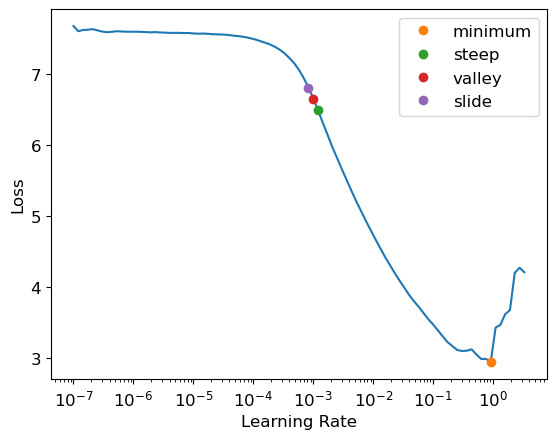

In [23]:
lrs = efnet_bin_learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

print("Valores propuestos: ", lrs)
print("\nValle (Smith Fit One cycle)", lrs[2])

In [24]:
# Etapa 1: Entrenamiento de la última capa
efnet_bin_learner.freeze()
efnet_bin_learner.fine_tune(1)
# Etapa 2: Descongelar y entrenar
efnet_bin_learner.unfreeze()
efnet_bin_learner.fit_one_cycle(20, lrs[2], cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3), wd=1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.068098,0.064930,0.911889,0.088111,03:40


epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(efnet_bin_learner, 1, trainSet.valid)

preds, targets = efnet_bin_learner.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [ ]:
report = classification_report(y_true, y_pred)
print(report)

In [ ]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Balanced accuracy: {balanced_acc * 100:.4f}")
print(f"Precision: {prec * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")